# Image data sets

In [68]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import FFHQStyleGAN2DLoader
from experiments.architectures.image_transforms import create_image_transform
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow
import plot_settings as ps


In [69]:
ps.setup()

## Options

In [70]:
highres = False
transform = False


## Helper function to go from torch to numpy conventions

In [71]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Transform images to numpy arrays (only need to do this once)

In [72]:
def load_pngs(filename, range_):
    imgs = np.array([plt.imread(f"../data/samples/gan2d/{filename}.png".format(i)).astype(np.float) for i in range_])
    imgs = np.transpose(imgs, [0,3,1,2])  # Want (batch, c, h, w)
    return imgs

if transform:
    np.save("../data/samples/gan2d/grid.npy", load_pngs("grid/grid_64_{:04}", range(81)))
    np.save("../data/samples/gan2d/grid_highres.npy", load_pngs("grid/grid_1024_{:04}", range(81)))
    np.save("../data/samples/gan2d/train.npy", load_pngs("train_test/subspace_64_{:05}", range(1, 10001)))
    np.save("../data/samples/gan2d/train_highres.npy", load_pngs("train_test/subspace_1024_{:05}", range(1, 101)))
    np.save("../data/samples/gan2d/test.npy", load_pngs("train_test/subspace_64_{:05}", range(10001, 11001)))


## Load models

In [73]:
def load_model(
    filename,
    outerlayers=20,
    innerlayers=6,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=1,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        2,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=None,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=2,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.01,
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [74]:
mf = load_model("mf_2_gan2d_april")
pie = load_model("pie_2_gan2d_april")

## True (GAN) image manifold

In [15]:
boundary = 2.0
resolution = 9
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
gan_zs = np.vstack(each_grid).T

gan_images = np.load("../data/samples/gan2d/grid{}.npy".format("_highres" if highres else ""))
gan_images.shape

(81, 3, 64, 64)

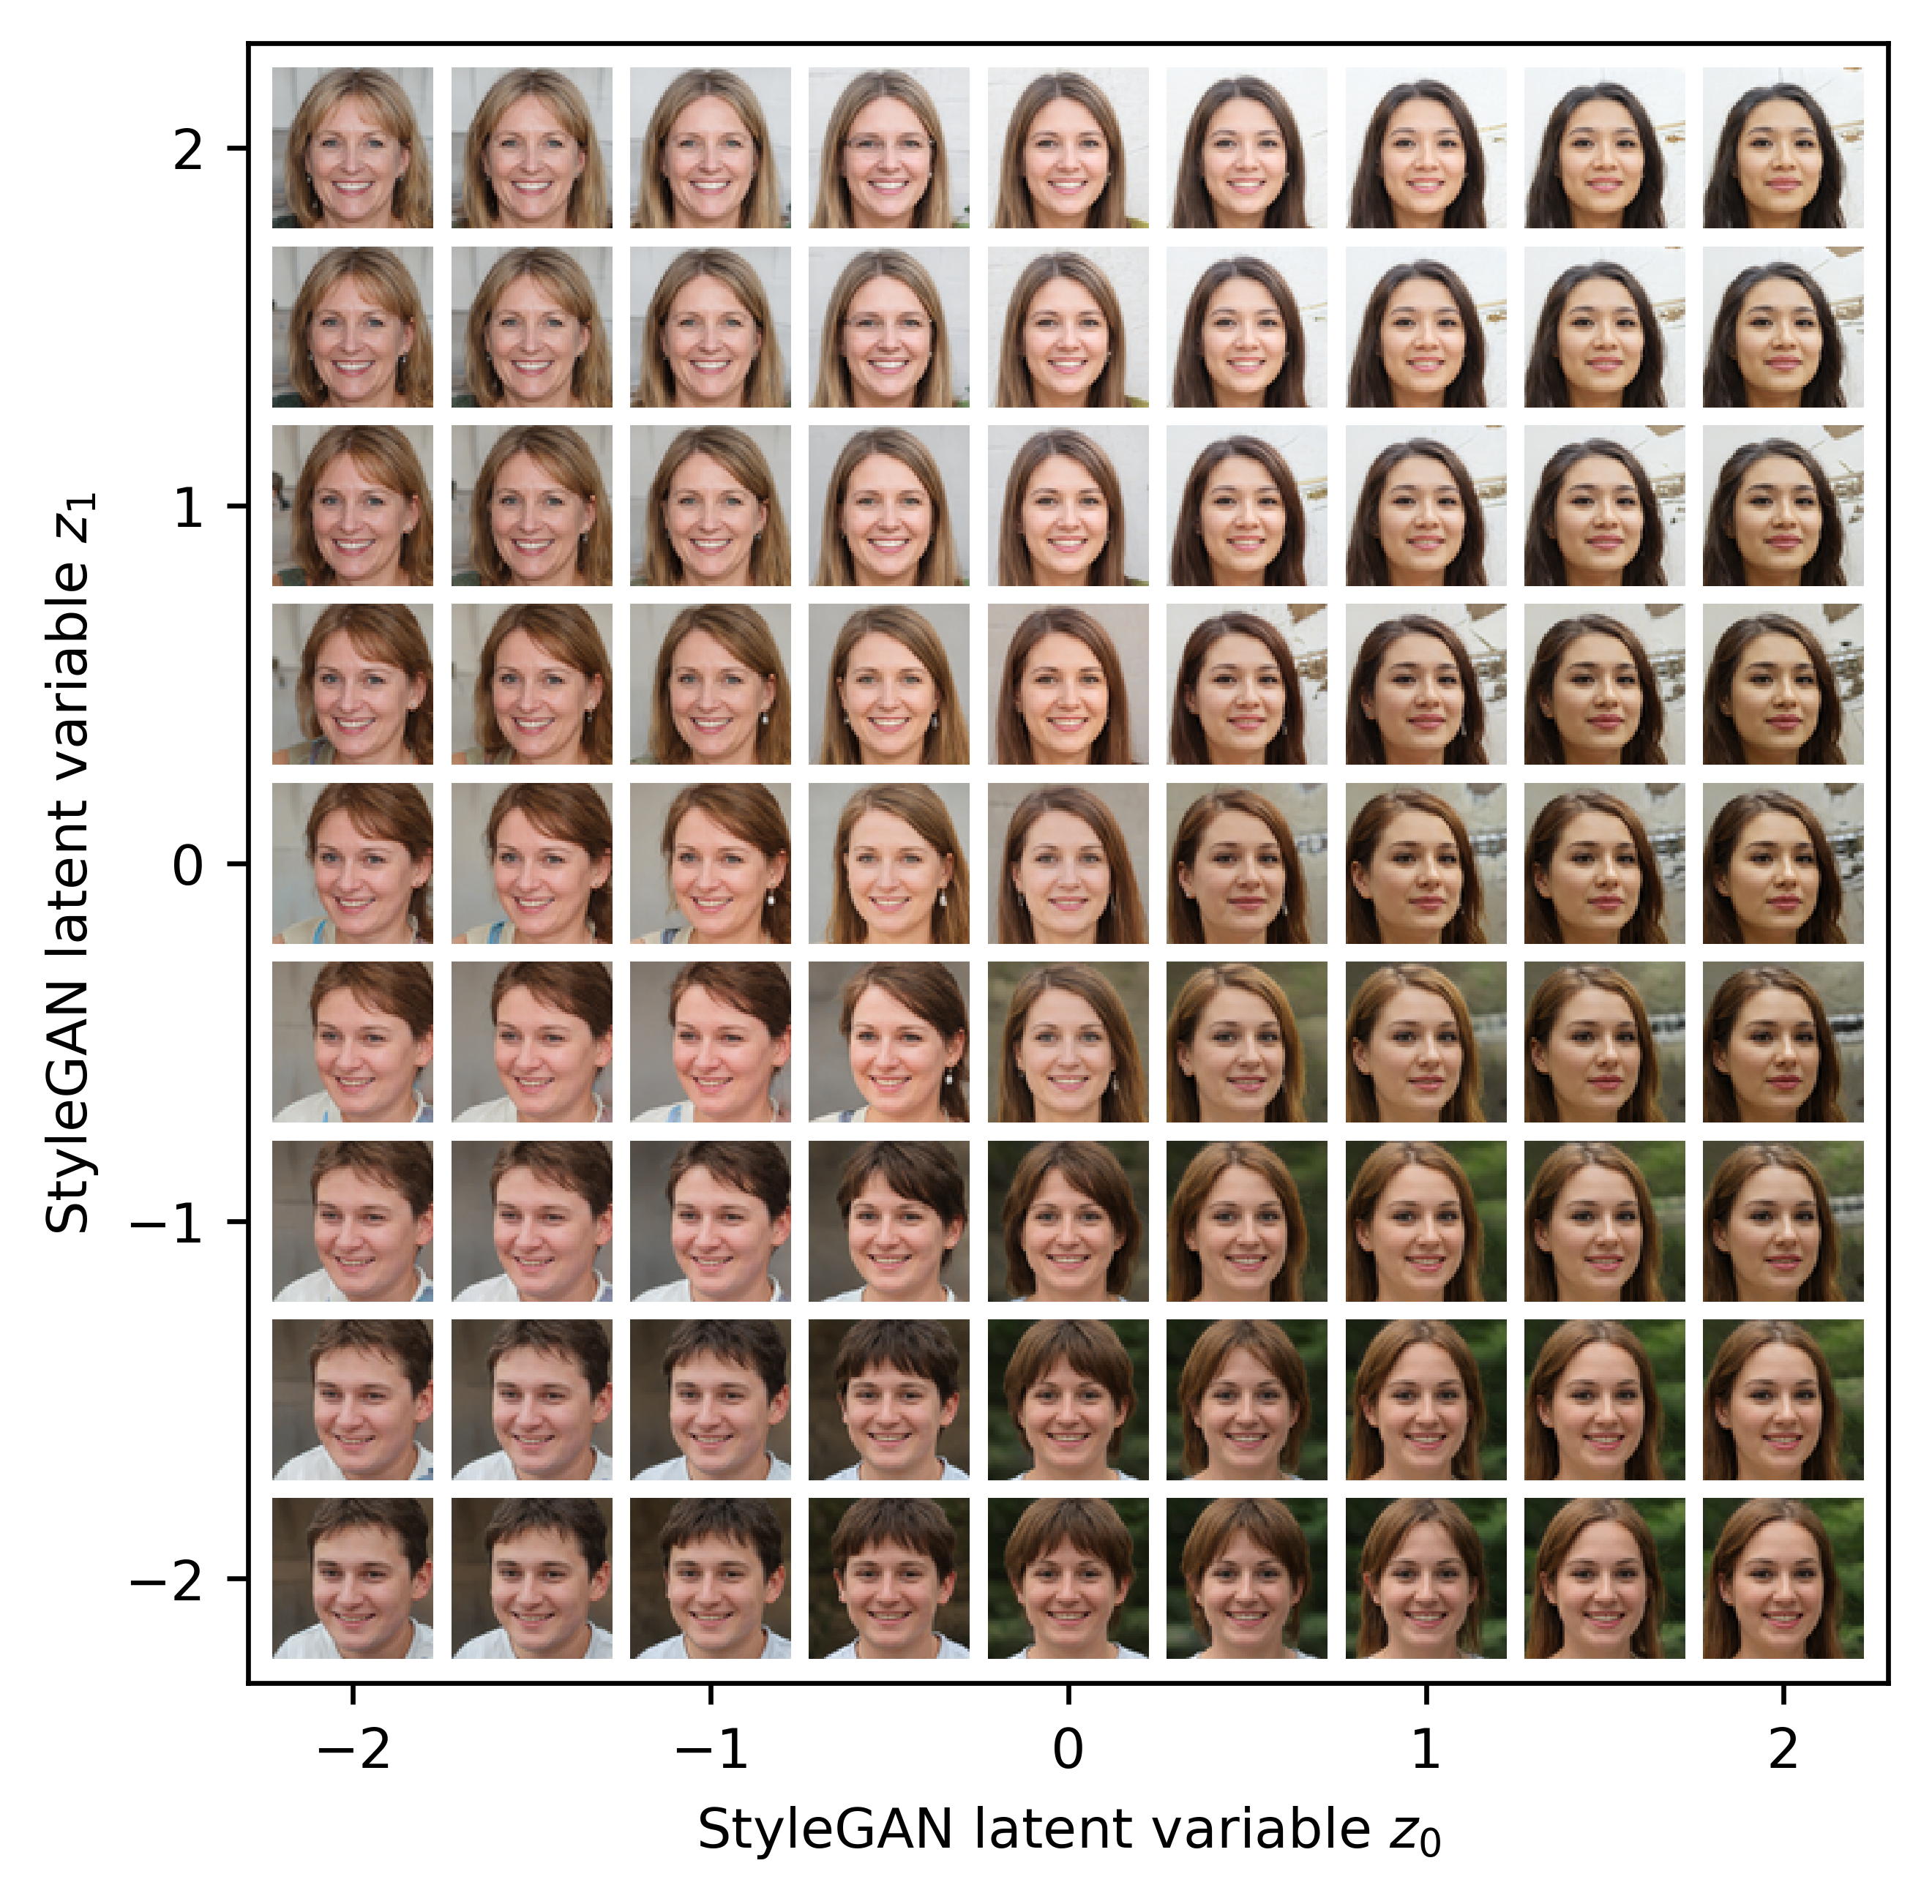

In [16]:
size = 0.45
fig, ax = ps.figure(height=0.5*ps.TEXTWIDTH)

for z, image in zip(gan_zs, gan_images):
    image_ = np.transpose(image, [1,2,0])
    plt.imshow(image_, extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel("StyleGAN latent variable $z_0$")
plt.ylabel("StyleGAN latent variable $z_1$")
plt.xlim(-2 - 1.3*size/2, 2 + 1.3*size/2)
plt.ylim(-2 - 1.3*size/2, 2 + 1.3*size/2)

plt.savefig("../figures/gan2d_grid.pdf", dpi=600)
    

## MF manifold

In [17]:
boundary = 2.0
resolution = 9
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
mf_zs = np.vstack(each_grid).T

z_ = torch.tensor(mf_zs, dtype=torch.float)
mf_images = mf.sample(u=z_, n=resolution**2).detach().numpy()
mf_images.shape


(81, 3, 64, 64)

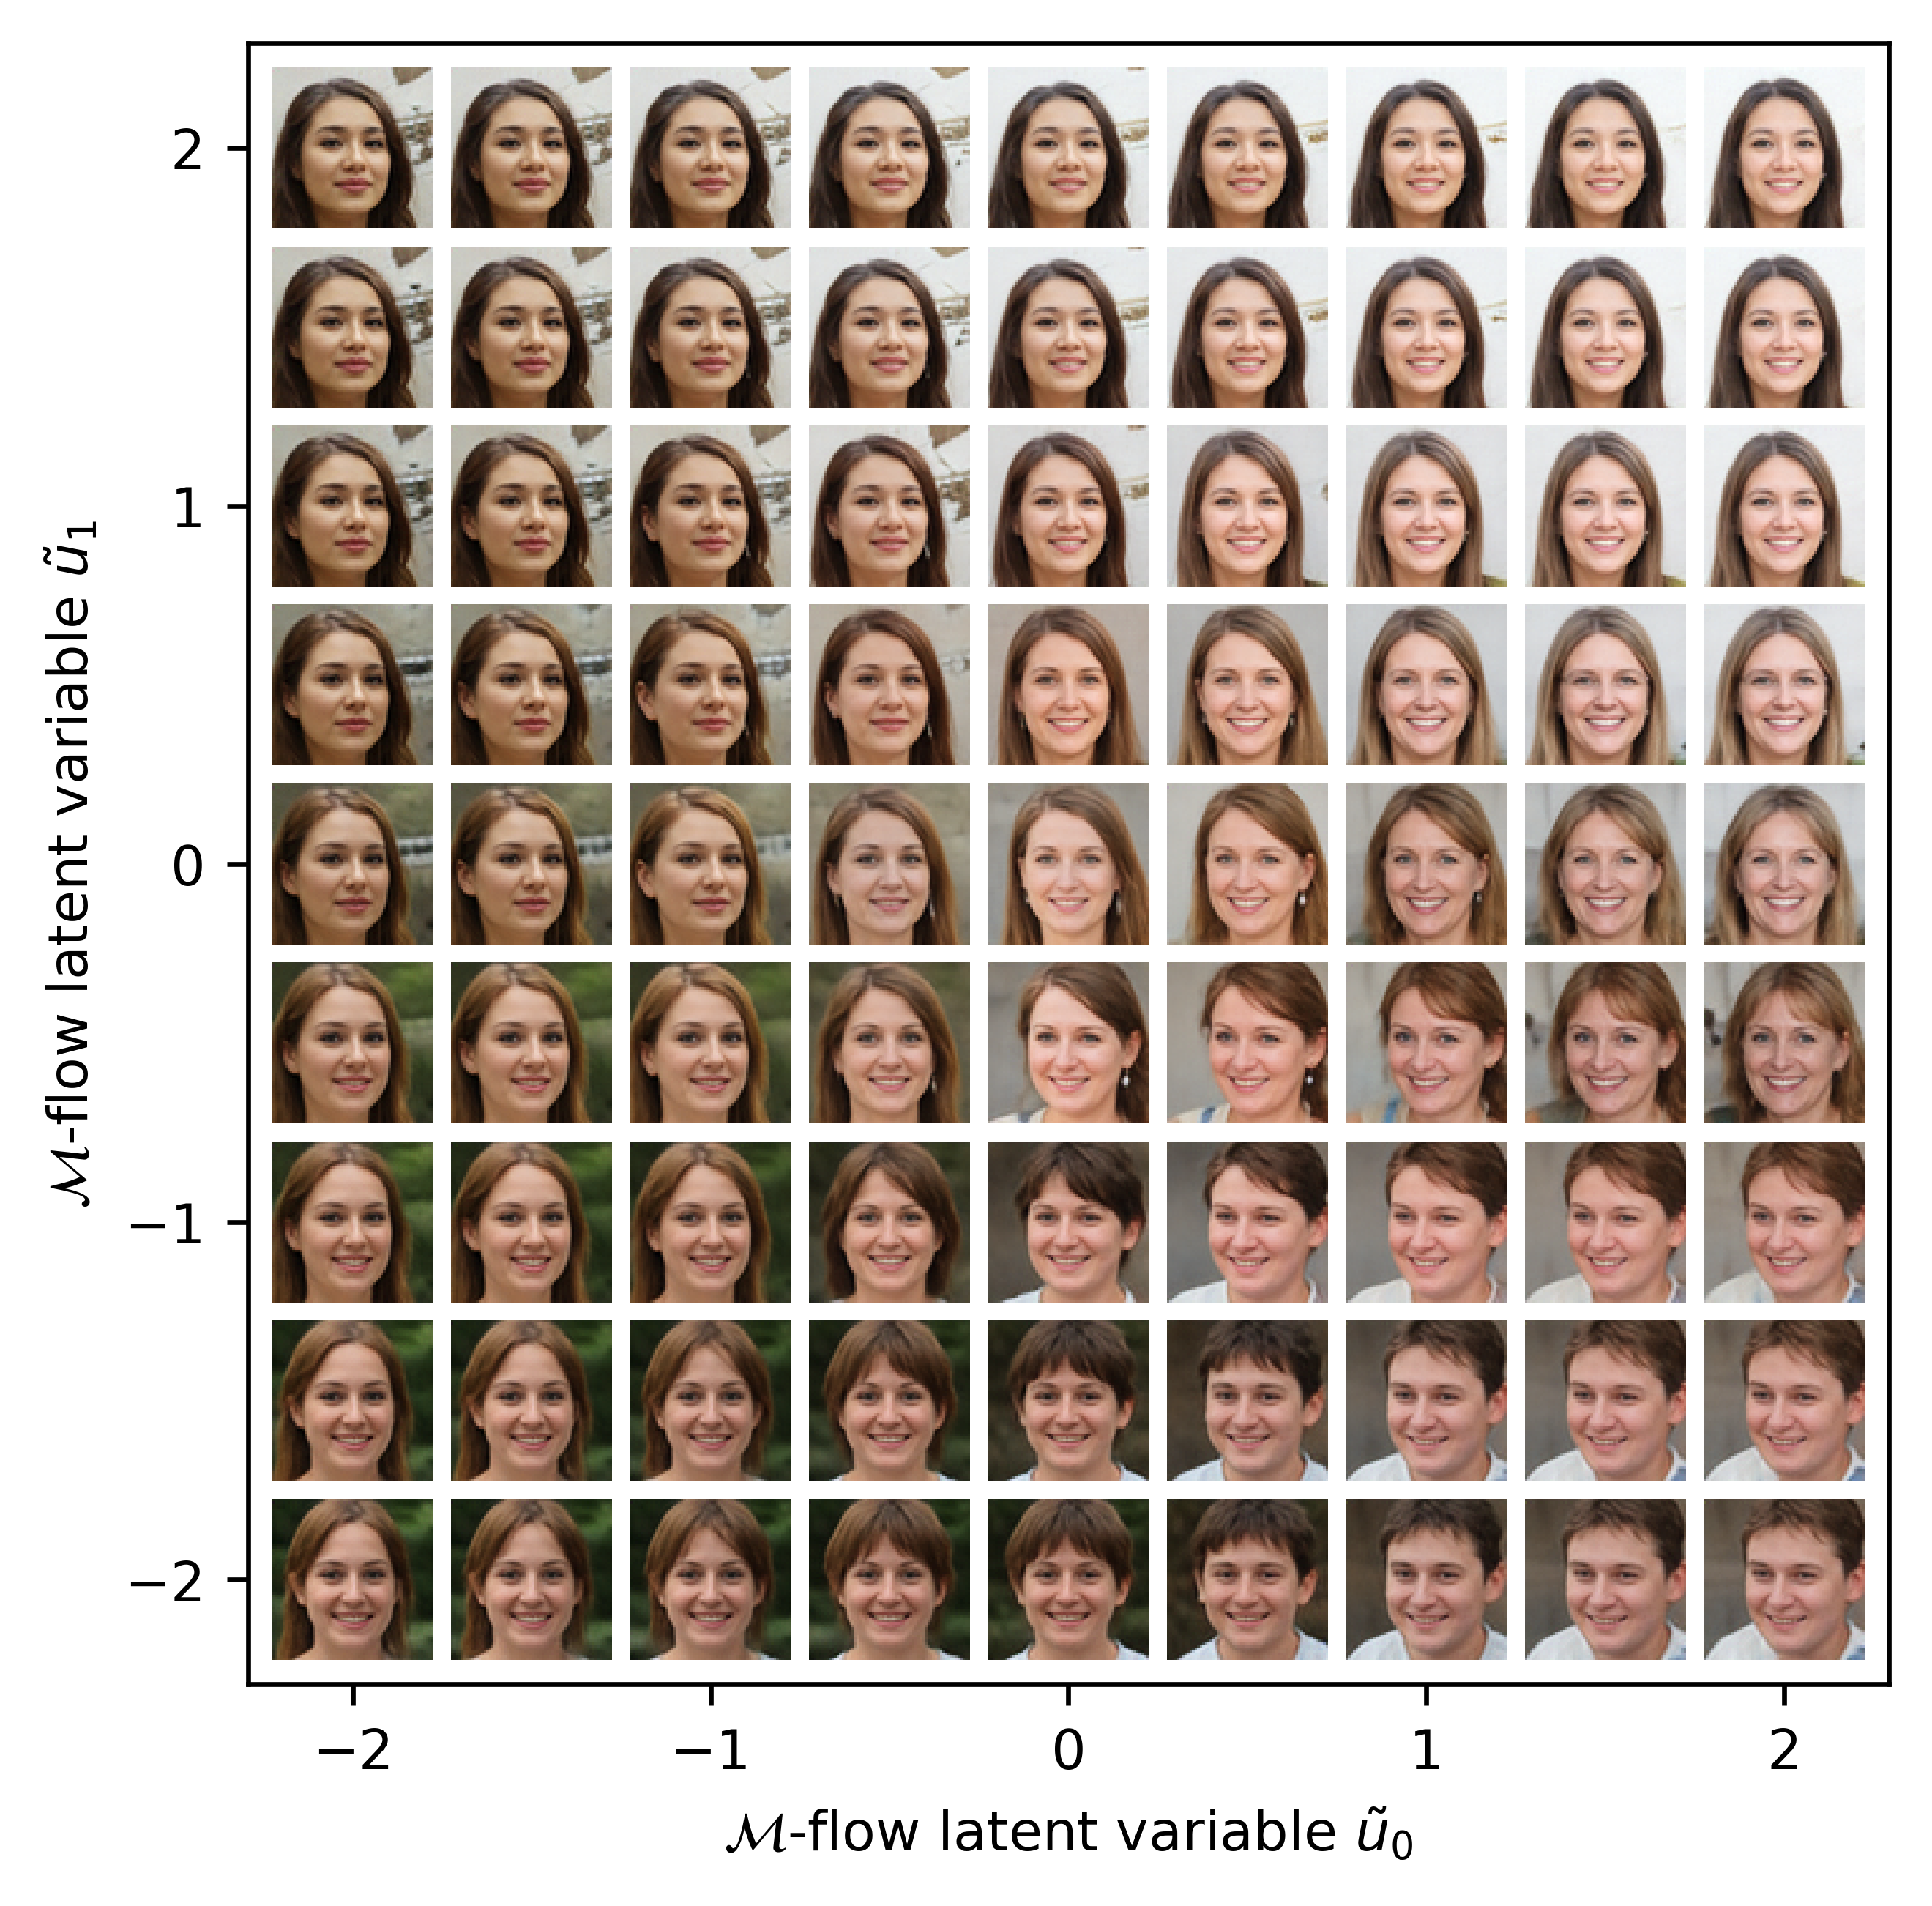

In [28]:
size = 0.45
fig, ax = ps.figure(height=0.5*ps.TEXTWIDTH)

for z, image in zip(mf_zs, mf_images):
    plt.imshow(trf(image), extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel(r"$\mathcal{M}$-flow latent variable $\tilde{u}_0$")
plt.ylabel(r"$\mathcal{M}$-flow latent variable $\tilde{u}_1$")
plt.xlim(-2 - 1.3*size/2, 2 + 1.3*size/2)
plt.ylim(-2 - 1.3*size/2, 2 + 1.3*size/2)

plt.savefig("../figures/gan2d_mf_grid.pdf", dpi=600)
    

## PIE manifold

In [22]:
boundary = 2.0
resolution = 9
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
pie_zs = np.vstack(each_grid).T

z_ = torch.tensor(pie_zs, dtype=torch.float)
pie_images = pie.sample(u=z_, n=resolution**2, sample_orthogonal=True).detach().numpy()
pie_images.shape


(81, 3, 64, 64)

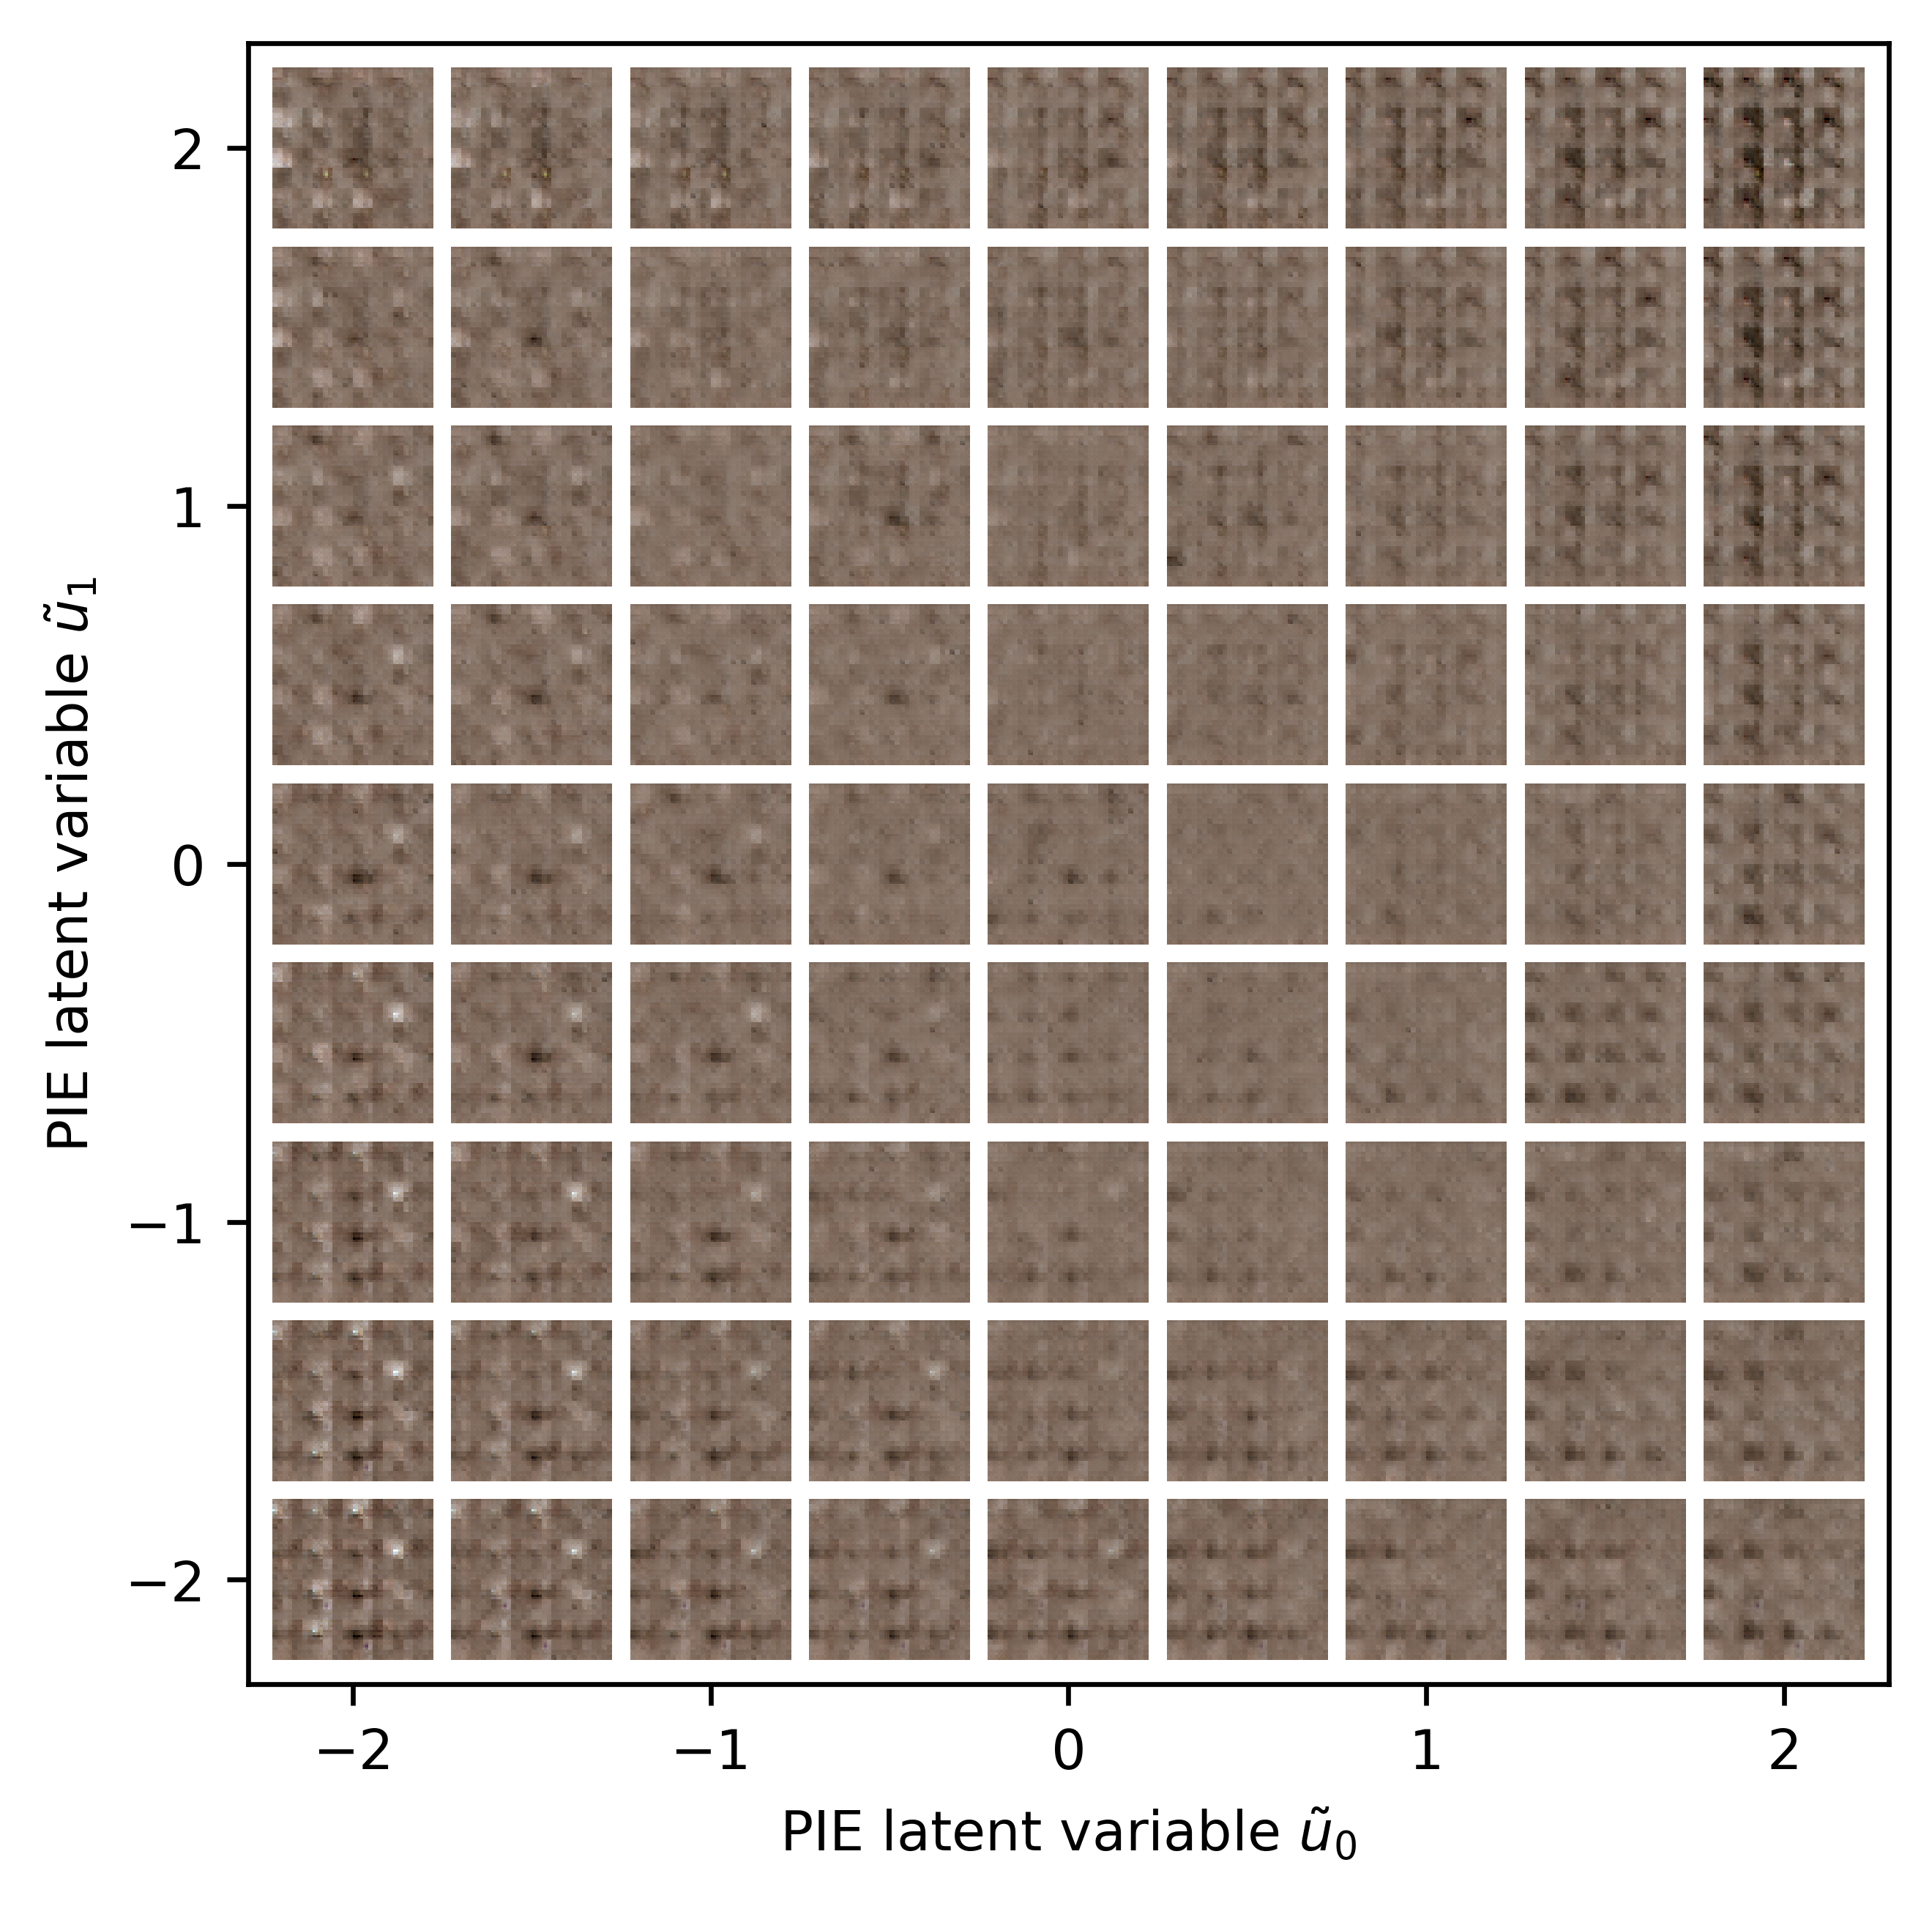

In [29]:
size = 0.45
fig, ax = ps.figure(height=0.5*ps.TEXTWIDTH)

for z, image in zip(mf_zs, pie_images):
    plt.imshow(trf(image), extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.xlabel(r"PIE latent variable $\tilde{u}_0$")
plt.ylabel(r"PIE latent variable $\tilde{u}_1$")
plt.xlim(-2 - 1.3*size/2, 2 + 1.3*size/2)
plt.ylim(-2 - 1.3*size/2, 2 + 1.3*size/2)

plt.savefig("../figures/gan2d_pie_grid.pdf", dpi=600)
    

## Test samples and projections to learned manifolds

In [86]:
test_idx=[0,1,3,8]
n_test = len(test_idx)
x_test = 0.5 + 255. * np.load("../data/samples/gan2d/test.npy")[test_idx]
x_reco_mf = np.load("../data/results/mf_2_gan2d_april_model_x_reco_test.npy")[test_idx]
x_reco_pie = np.load("../data/results/pie_2_gan2d_april_model_x_reco_test.npy")[test_idx]


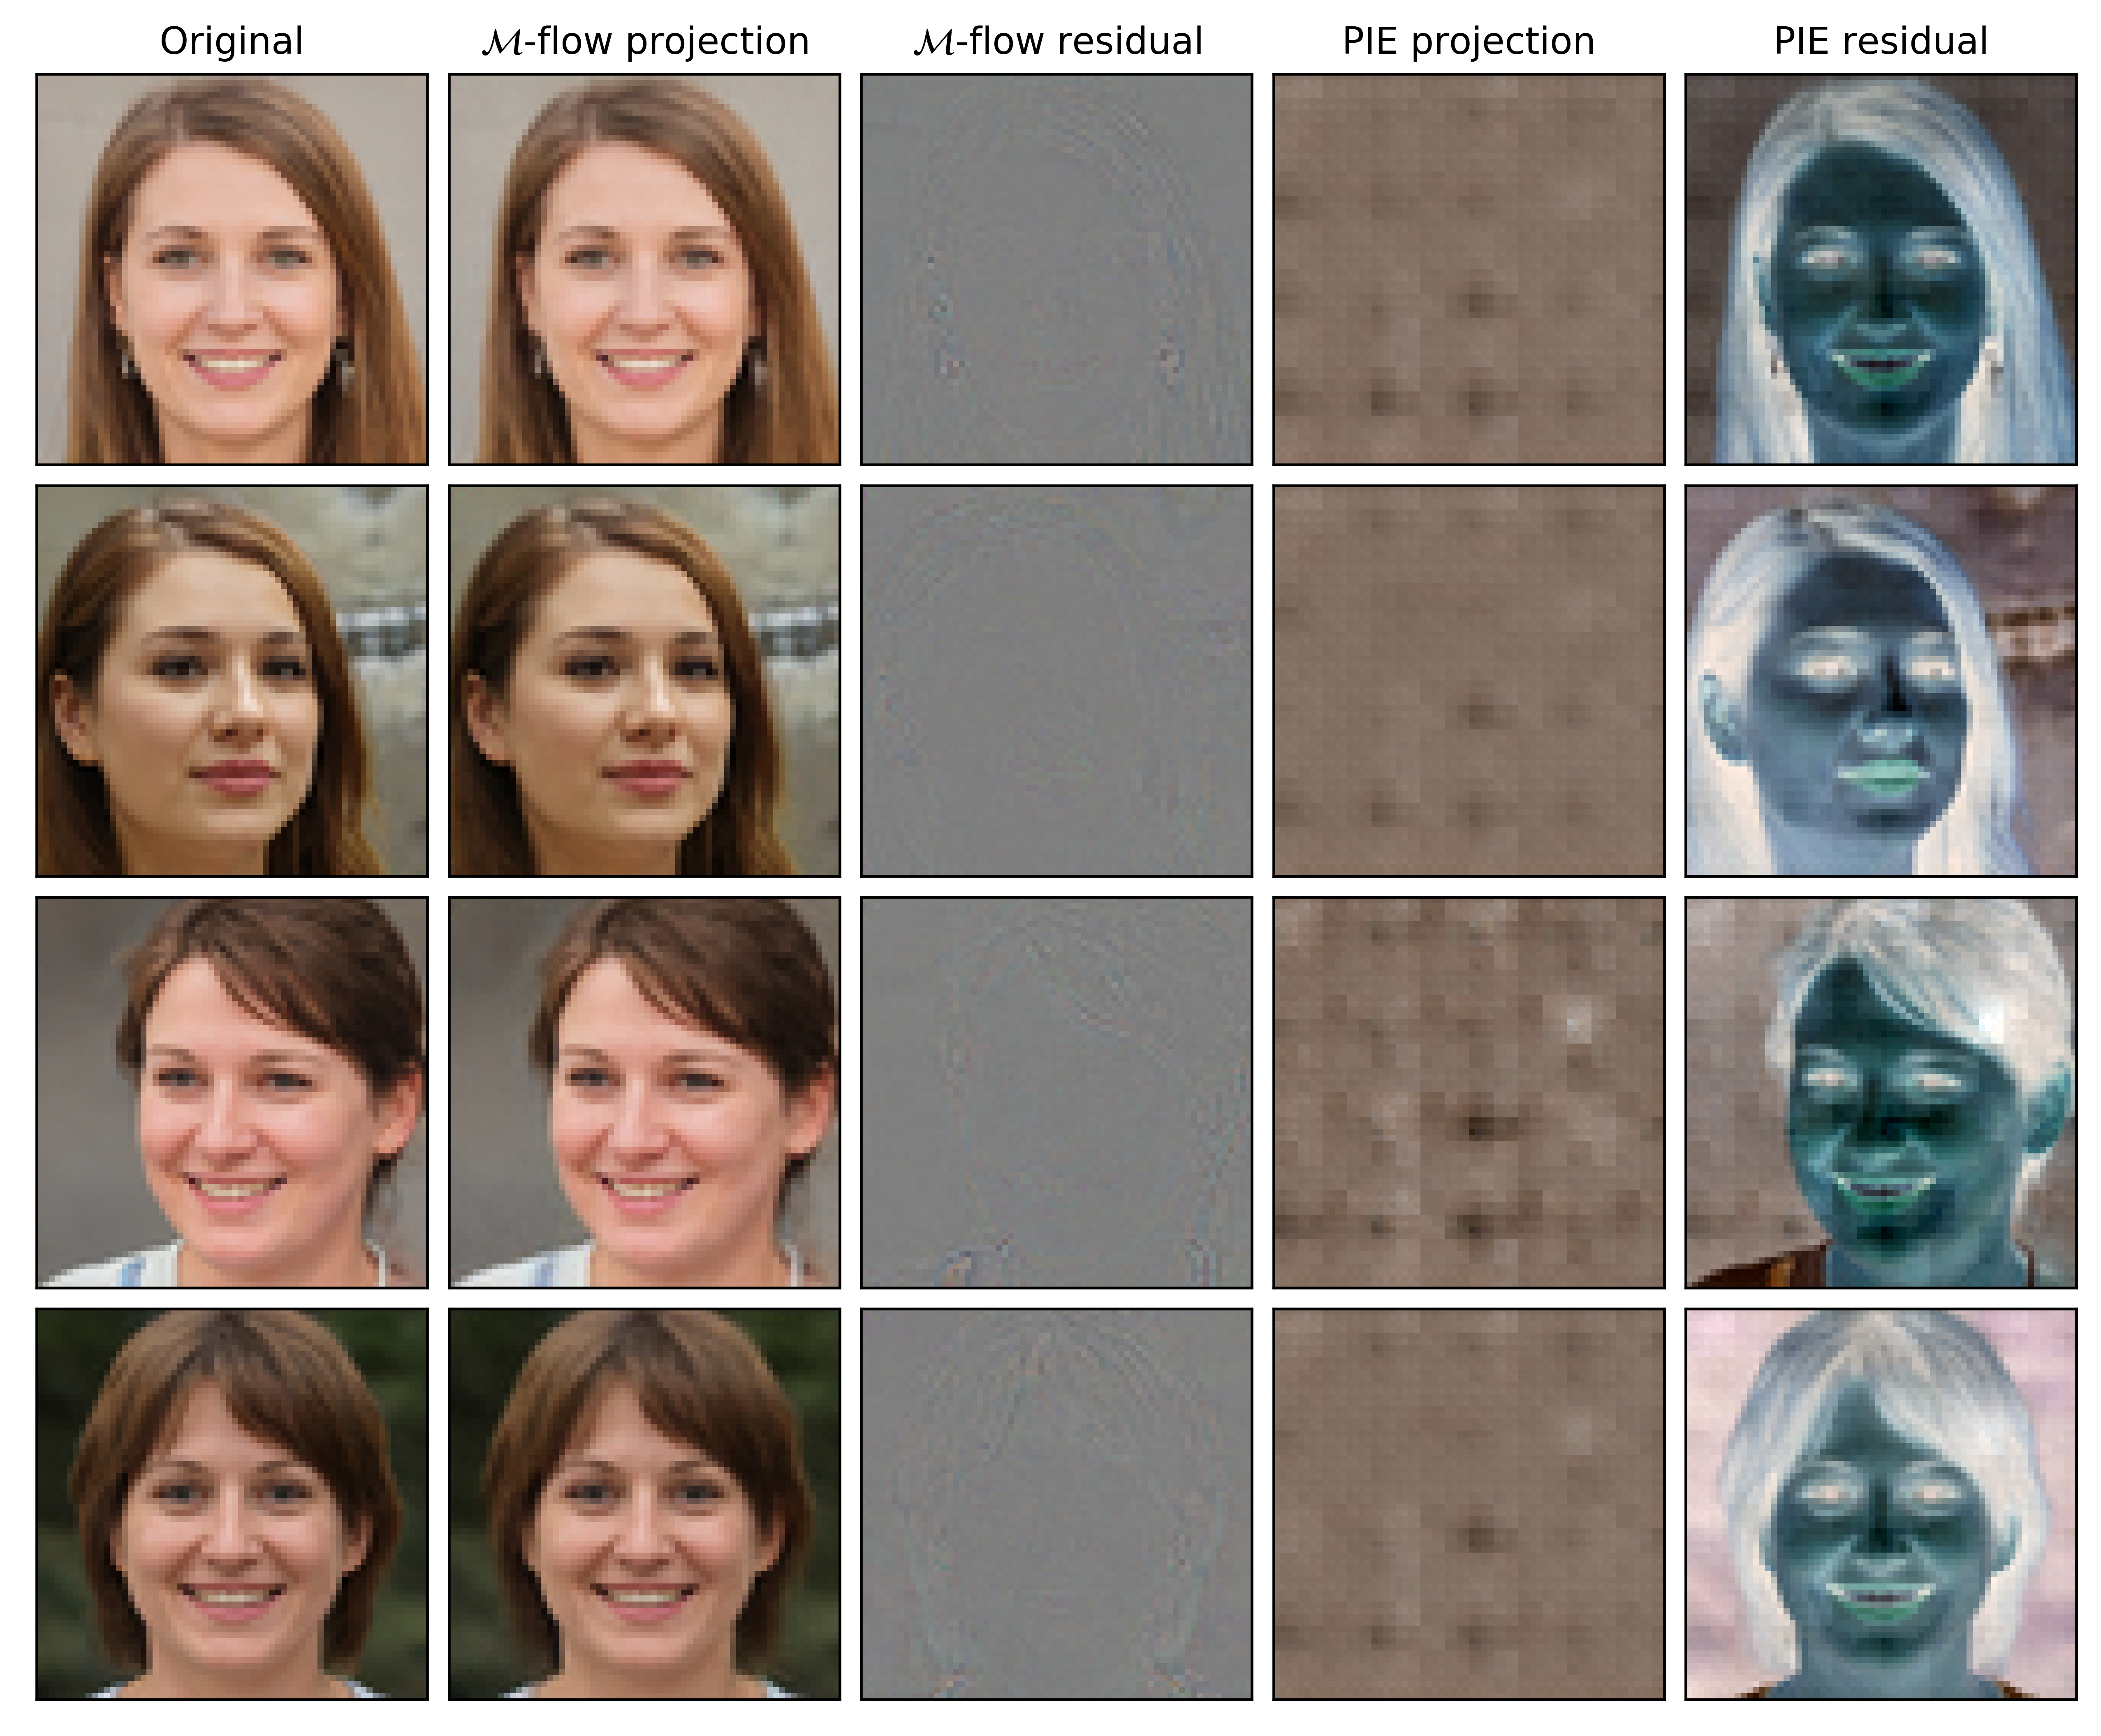

In [92]:
fig, gs = ps.grid_width(5, n_test, width=ps.TEXTWIDTH, large_margin=0.05, small_margin=0.05, sep=0.01)

for i in range(n_test):
    # Test image
    ax = plt.subplot(gs[i*5 + 0])
    plt.imshow(trf(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i == 0:
        plt.title("Original")
    
    # Reco MF
    ax = plt.subplot(gs[i*5 + 1])
    plt.imshow(trf(x_reco_mf[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i == 0:
        plt.title("$\mathcal{M}$-flow projection")
    
    # Residuals MF
    ax = plt.subplot(gs[i*5 + 2])
    plt.imshow(0.5 + trf(x_reco_mf[i]) - trf(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i == 0:
        plt.title("$\mathcal{M}$-flow residual")
    
    # Reco PIE
    ax = plt.subplot(gs[i*5 + 3])
    plt.imshow(trf(x_reco_pie[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i == 0:
        plt.title("PIE projection")
    
    # Residuals PIE
    ax = plt.subplot(gs[i*5 + 4])
    plt.imshow(0.5 + trf(x_reco_pie[i]) - trf(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i == 0:
        plt.title("PIE residual")
    
plt.savefig("../figures/gan2d_projections.pdf")


## Training samples

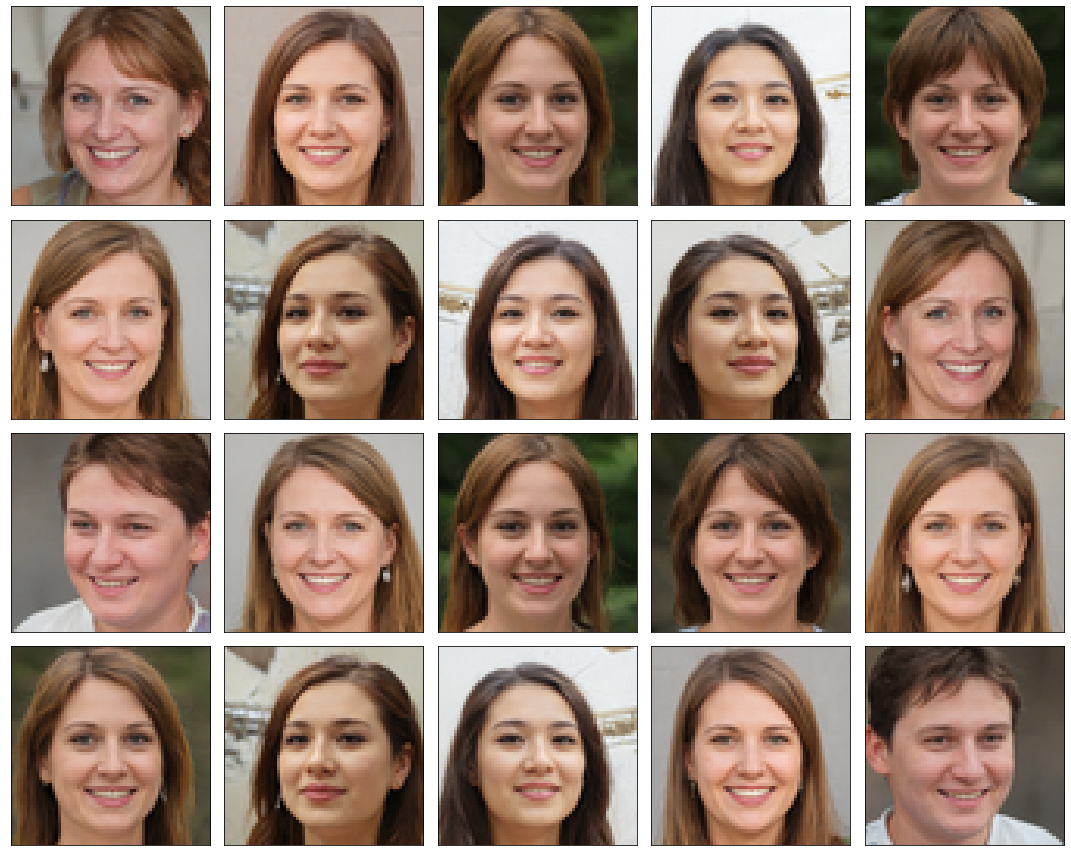

In [48]:
loader = FFHQStyleGAN2DLoader()
data = loader.load_dataset(train=False, dataset_dir="../data/samples/gan2d")
    
fig = plt.figure(figsize=(5*3., 4*3.))

for i in range(20):
    x, _ = data[np.random.randint(len(data) - 1)]
    x_ = np.transpose(np.array(x), [1,2,0]) / 256.
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(x_)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
